<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/class_26_multiclase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table> 

# Clasificación multietiqueta: Clase 27 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Obtención de los datos 
from sklearn.datasets import fetch_openml

# algoritmos de preprocesamiento
from sklearn.preprocessing import StandardScaler

# algoritmos de clasificación




In [2]:
%%time 
mnist = fetch_openml('mnist_784', version = 1, as_frame = False) 

Wall time: 41.4 s


In [3]:
X,y = mnist['data'], mnist['target'] 

# Conversión de `str` a `int64`

In [4]:
y = y.astype(np.int64)

In [5]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:] 

# Elijo un modelo de clasificación 

In [ ]:
from sklearn.linear_model import SGDClassifier 

# Instanciar la clase 

In [ ]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# Entrenar nuestro clasificador con los datos de entrenamiento 

In [ ]:
%%time
sgd_clf.fit(X_train, y_train) 

In [ ]:
sgd_clf.predict([X_train[2]])

# La validación cruzada con la medida de desempeño de la exactitud 

In [ ]:
%%time 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [ ]:
from sklearn.model_selection import cross_val_score 

In [ ]:
%%time 

puntajes = cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy') 

In [ ]:
puntajes 

Nota:  

`shuffle=True` se omitió por error en versiones anteriores del libro.

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
%%time 

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

## Conclusión

La exactitud o accuracy no es una buena medida de desempeño cuando al sesgo en las clases 

# Constitución de la matriz de confusión 

In [ ]:
from sklearn.model_selection import cross_val_predict 

In [ ]:
from sklearn.metrics import confusion_matrix 

In [ ]:
%%time 
y_predicciones_train = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [ ]:
len(y_predicciones_train) 

In [ ]:
confusion_matrix(y_train_5, y_predicciones_train)

# Precisión 

$$ \text{precision} = \frac{TP}{TP + FP} $$

Nos dice cuandas veces predijo bien en cuanto a la clase positiva 

# Recall 

$$ \text{recall} = \frac{TP}{TP + FN} $$

Poder de detección del modelo

In [ ]:
from sklearn.metrics import precision_score, recall_score  

In [ ]:
 precision_score(y_train_5, y_predicciones_train) 

In [ ]:
recall_score(y_train_5, y_predicciones_train)

Ahora su 5 - detector no se ve tan brillante como cuando miró su exactitud.

Cuando afirma que una imagen representa un 5, es correcta solo el 72,9% de las veces.

Además, solo detecta el 75,6% de los 5s.

# Combinación de precision y recall 

* A menudo, es conveniente combinar la precisión y la recuperación en una sola métrica denominada puntuación $F_{1}$, 

* en particular si necesita una forma sencilla de comparar dos clasificadores.

La puntuación $F_{1}$ es la media armónica de precisión y recuperación.

Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. 

Como resultado, el clasificador solo obtendrá una puntuación alta de $F_{1}$ si tanto la recuperación como la precisión son altas.

$$ F_{1} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}} } = 2 \cdot \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}   $$

Para calcular la puntuación $F_{1}$, simplemente llame a la función `f1_score()`:

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_predicciones_train )

La puntuación $F_{1}$ favorece a los clasificadores que tienen una precisión y recuperación similares.

Esto no siempre es lo que desea:  

* en algunos contextos, lo que más le importa es la precisión, y  

* en otros contextos realmente le importa recordar.

**Por ejemplo, si entrenó un clasificador para detectar videos que son seguros para los niños**, 
* probablemente preferiría un clasificador que rechace muchos videos buenos (baja recuperación)  
* pero solo mantenga los seguros (alta precisión), 

* en lugar de un clasificador que tiene mucho más recall, pero permite que aparezcan algunos videos realmente malos en su producto 

(en tales casos, es posible que desee agregar una canalización humana para verificar la selección de videos del clasificador).

Por otro lado, suponga que entrena **un clasificador para detectar ladrones en imágenes de vigilancia**:  

probablemente esté bien si su clasificador tiene solo un 30 % de precisión siempre que tenga un 99 % de recuperación (claro, los guardias de seguridad recibirán algunas alertas falsas, pero casi todos los ladrones serán atrapados).

* Desafortunadamente, no puede tener las dos cosas: 

* aumentar la precisión reduce la recuperación y viceversa.

Esto se llama equilibrio entre precisión/recuperación.

## Compensación Precision/Recall 

Para comprender esta compensación, veamos cómo `SGDClassifier` toma sus decisiones de clasificación.

Para cada instancia, calcula una puntuación basada en una función de decisión.

* Si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva; 
* de lo contrario, lo asigna a la clase negativa.

La Figura 3-3 muestra algunos dígitos ubicados desde la puntuación más baja a la izquierda hasta la puntuación más alta a la derecha.

<img src = 'https://github.com/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/figura_3_3_various_thresholds.jpg?raw=true'>

Suponga que el umbral de decisión se coloca en la flecha central (entre los dos 5): 

* encontrará 4 verdaderos positivos (5 reales) a la derecha de ese umbral y 
* 1 falso positivo (en realidad, un 6).

Por tanto, con ese umbral, la precisión es del 80% (4 sobre 5).

Por tanto, con ese umbral, la precisión es del 80% (4 sobre 5).

Si subes el umbral (muévelo hacia la flecha de la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, aumentando así la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo , disminuyendo el recuerdo hasta un 50%.

Por el contrario, bajar el umbral aumenta la recuperación y reduce la precisión.

Scikit-Learn no le permite establecer el umbral directamente, pero le da acceso a los puntajes de decisión que utiliza para hacer predicciones.

En lugar de llamar al método `predict()` del clasificador, puede llamar a su método `decision_function()`, que devuelve un puntaje para cada instancia, y luego usar cualquier umbral que desee para hacer predicciones basadas en esos puntajes:

In [ ]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores


In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method (i.e., True). 

Let’s raise the threshold:

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

This confirms that raising the threshold decreases recall. 

The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

# ¿Cómo se decide qué umbral usar? 

Primero, use la función `cross_val_predict()` para obtener **los puntajes** de todas las instancias en el conjunto de entrenamiento,  

* pero esta vez especifique que desea obtener puntajes de decisión en lugar de predicciones:

In [ ]:
%%time 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Con estas puntuaciones, utilice la función `precision_recall_curve()` para calcular la precisión y la recuperación de todos los umbrales posibles:

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finalmente, use Matplotlib para trazar la precisión y recordar como funciones del valor del umbral:

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid() 
    plt.legend() 
    plt.xlabel('umbrales')
    [...] # highlight the threshold and add the legend, axis label, and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<img src = 'https://github.com/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/figura_3_4_thresholds.jpg?raw=true'>

## NOTE

Quizás se pregunte por qué la curva de precisión es más irregular que la curva de recuperación.

The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). 

Para entender por qué, vuelva a mirar la Figura de puntajes crecientes y observe lo que sucede cuando comienza desde el umbral central y lo mueve solo un dígito a la derecha:   

* la precisión va de 4/5 (80 %) a 3/4 (75 %). ).

Por otro lado, la recuperación solo puede disminuir cuando se aumenta el umbral, lo que explica por qué su curva parece suave.

# Gráfica de Precisión versus recuerdo 

Otra forma de seleccionar una buena compensación de precisión/recuperación es trazar la precisión directamente contra la recuperación, como se muestra en la siguiente figura (se resalta el mismo umbral que antes).

<img src = 'https://github.com/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/figura_3_5_recall_precision.jpg?raw=true'>

Puede ver que la precisión realmente comienza a caer bruscamente alrededor del 80% de recuperación.

You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. 

But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. 

You look up the first plot and find that you need to use a threshold of about 8,000. 

# Configurar el modelo para tener un 90% de precisión

* Para ser más preciso, puede buscar el umbral más bajo que le proporcione al menos un $90 \%$ de precisión. 

* (`np.argmax()` le dará el primer índice del valor máximo, que en este caso significa el primer valor Verdadero):

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let’s check these predictions’ precision and recall:

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

Great, you have a 90% precision classifier! 

Como puede ver, es bastante fácil crear un clasificador con prácticamente cualquier precisión que desee: simplemente establezca un umbral lo suficientemente alto y listo. 

Pero espera, no tan rápido.

A high-precision classifier is not very useful if its recall is too low!

## Sigerencia 

Si alguien dice: "Lleguemos al $99 \%$ de precisión", debe preguntar: "¿Con qué recuperación?"

## The ROC Curve

La curva de **Características Operativas del Receptor (ROC)** es otra herramienta común utilizada con clasificadores binarios.

Es muy similar a la curva de precisión/recuperación, pero en lugar de trazar precisión versus recuperación, la curva ROC representa la tasa de verdaderos positivos (otro nombre para recuperación) contra la tasa de falsos positivos (FPR).

The FPR is the ratio of negative instances that are incorrectly classified as positive. 

It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. 

The TNR is also called specificity. 

Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib. 

This code produces the plot in Figure 3-6:

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. 

La línea punteada representa la curva ROC de un clasificador puramente aleatorio; un buen clasificador se mantiene lo más lejos posible de esa línea (hacia la esquina superior izquierda).

<img src = 'https://github.com/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/figura_3_6_false_positive_rate_vs_true_positive_rate.jpg?raw=true'>

One way to compare classifiers is to measure the area under the curve (AUC). 

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

## TIP

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. 

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. 

Otherwise, use the ROC curve. 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good.

Pero esto se debe principalmente a que hay pocos positivos (5s) en comparación con los negativos (no 5s).

In contrast, the PR curve makes it clear that the classifier has room for improvement
(the curve could be closer to the top-left corner).

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier. First, you need to get scores for each instance in the training set. 

But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a
decision_function() method. Instead, it has a predict_proba() method. 

Scikit-Learn classifiers generally have one or the other, or both.

The predict_proba() method returns an array containing a row per
instance and a column per class, each containing the probability that the
given instance belongs to the given class (e.g., 70% chance that the image
represents a 5):

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method="predict_proba")

The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities. 

Let’s use the positive class’s probability as the score:

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest =
roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. 

It is useful to plot the first ROC curve as well to see how they compare (Figure 3-7):

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

<img src = 'https://github.com/marco-canas/intro-Machine-Learning/blob/main/classes/class_26_multiclase/figura_3_7_sgd_random_forest.jpg?raw=true'>

As you can see in Figure 3-7, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

Try measuring the precision and recall scores: you should find 99.0% precision and 86.6% recall. 

# Conclusión acerca de los clasificadores binarios

Ahora sabe **cómo entrenar clasificadores binarios**, 

* elegir la métrica adecuada para su tarea,   
* evaluar sus clasificadores mediante validación cruzada,   
* seleccionar la compensación de precisión/recuperación que se ajuste a sus necesidades y   
* usar curvas ROC y puntajes ROC AUC para comparar varios modelos. .

Now let’s try to detect more than just the 5s.

## Multiclass Classification

Mientras que los clasificadores binarios distinguen entre dos clases, 

* los clasificadores multiclase (también llamados clasificadores multinomiales) pueden distinguir entre más de dos clases.

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively.

Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. 

However, there are various strategies that you
can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). 

Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. 

This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. 

This is called the one-versus-one (OvO) strategy. 

Si hay $N$ clases, necesita entrenar $ N \times (N – 1) / 2 $ clasificadores.

For the MNIST problem, this means training 45 binary classifiers! 

When you want to classify an image, you have to run the image through all 45 classifiers and
see which class wins the most duels. 

The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. 

For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. 

For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. 

Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class:

In [ ]:
%%time 
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5

In [ ]:
svm_clf.predict([X[4]]) 

That was easy! 

Este código entrena al SVC en el conjunto de entrenamiento usando las clases de destino originales de 0 a 9 (y_train), en lugar de las clases de destino de 5 contra el resto (y_train_5).

Then it makes a prediction (a correct one in this case). 

Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the `decision_function()` method, you will see that it returns 10 scores per instance (instead of just 1). 

That’s one score per class: 

In [ ]:
some_digit_scores = svm_clf.decision_function([X[0]])
some_digit_scores

The highest score is indeed the one corresponding to class 5:

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

## WARNING

When a classifier is trained, it stores the list of target classes in its classes_ attribute,
ordered by value. 

In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.

If you want to force Scikit-Learn to use one-versus-one or one-versus-therest,
you can use the OneVsOneClassifier or OneVsRestClassifier classes. 

Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). 

For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [ ]:
%%time 
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

In [ ]:
ovr_clf.predict([X[0]])

In [ ]:
len(ovr_clf.estimators_)

Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [ ]:
from sklearn.linear_model import SGDClassifier 

In [ ]:
sgd_clf_multi = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 513) 

In [ ]:
sgd_clf_multi.fit(X_train, y_train)

In [ ]:
sgd_clf_multi.predict([X[0]]) 

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. 

The decision_function() method now returns one value per class. 

Let’s look at the score that the SGD classifier assigned to each class:

In [ ]:
sgd_clf_multi.decision_function([X[0]]) 

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of 2412.5. 

The model has a slight doubt regarding class 3, which gets a score of 573.5.

Now of course you want to evaluate this classifier. 

As usual, you can use cross-validation. 

Utilice la función `cross_val_score()` para evaluar la precisión del `SGDClassifier`:

In [ ]:
%%time 

from sklearn.model_selection import cross_val_score 

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. 

If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. 

Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [ ]:
%%time 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
from sklearn.model_selection import cross_val_score 

cross_val_score(sgd_clf_multi, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis

Si se tratara de un proyecto real, ahora seguiría los pasos de la lista de verificación del proyecto de Machine Learning (consulte el Apéndice B).

Explorará las opciones de preparación de datos, probará varios modelos (preseleccionando los mejores y ajustando sus hiperparámetros usando `GridSearchCV`) y automatizando tanto como sea posible. 

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

Primero, mira la matriz de confusión. Debe hacer predicciones usando la función `cross_val_predict()`, luego llame a la función `confusion_matrix()`, tal como lo hizo antes:

In [ ]:
%%time 

from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

That’s a lot of numbers. 

It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. 

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. 

First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. 

Remember that rows represent actual classes, while columns represent predicted classes.

The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. 

However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. 

As you can see, the confusion matrix is not necessarily symmetrical. 

You can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix often gives you insights into ways to
improve your classifier. Looking at this plot, it seems that your efforts
should be spent on reducing the false 8s. 

For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. 

Or you could engineer new features that would help the classifier—for example, writing an
algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). 

Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights on what
your classifier is doing and why it is failing, but it is more difficult and
time-consuming. 

For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s. 

Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g.,
the 5 in the first row and second column truly looks like a badly written 3).

However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. 

The reason is that we used a simple SGDClassifier, which is a linear model. 

All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. 

So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. 

If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. 

In other words, this classifier is quite sensitive to image shifting and rotation. 

So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. 

Esto probablemente también ayudará a reducir otros errores.

## Multilabel Classification

Hasta ahora, cada instancia siempre se ha asignado a una sola clase.

En algunos casos, es posible que desee que su clasificador genere múltiples clases para cada instancia.

Considere un clasificador de reconocimiento facial:   

* ¿qué debería hacer si reconoce a varias personas en la misma imagen?

Debe adjuntar una etiqueta por persona que reconozca.

Digamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie.

Luego, cuando al clasificador se le muestre una imagen de Alice y Charlie, debería generar [1, 0, 1] (que significa "Alice sí, Bob no, Charlie sí").

Un sistema de clasificación de este tipo que genera múltiples etiquetas binarias se denomina sistema de clasificación de múltiples etiquetas.

Todavía no entraremos en el reconocimiento facial, pero veamos un ejemplo más simple, solo con fines ilustrativos:

In [ ]:
d= 7
d%2==0

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
y_train_large = (y_train >= 7)
y_train_large 

array([False, False, False, ..., False, False,  True])

In [8]:
y_train_odd = (y_train % 2 == 1)
y_train_odd 

array([ True, False, False, ...,  True, False, False])

In [9]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
y_multilabel[0] 

In [10]:
knn_clf = KNeighborsClassifier()

In [11]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Este código crea una matriz y_multilabel que contiene dos etiquetas objetivo para cada imagen de dígito:   

* la primera indica si el dígito es grande o no (7, 8 o 9) y   
* la segunda indica si es impar o no.

Las siguientes líneas crean una instancia de `KNeighborsClassifier` (que admite clasificación multietiqueta, aunque no todos los clasificadores lo hacen), y la entrenamos usando la matriz de objetivos múltiples.

Ahora puede hacer una predicción y notar que genera dos etiquetas:

In [ ]:
knn_clf.predict(X[:3])

¡Y lo hace bien! De hecho, el dígito 5 no es grande (Falso) e impar (Verdadero).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. 

One approach is to measure the $F_{1}$ score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. 

This code computes the average $F_{1}$ score across all labels:

In [15]:
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import f1_score 

In [13]:
%%time 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)

Wall time: 10min 38s


In [16]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, however, which may not be the case. 

In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. 

One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). 

To do this, simply set average="weighted" in the preceding code.

## Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput–multiclass classification (or simply multioutput classification).

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. 

Tomará como entrada una imagen de dígito ruidosa y (con suerte) generará una imagen de dígito limpia, representada como una matriz de intensidades de píxeles, al igual que las imágenes MNIST.

Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). 

It is thus an example of a multioutput classification system.

## NOTE

The line between classification and regression is sometimes blurry, such as in this example. 

Arguably, predicting pixel intensity is more akin to regression than to
classification. 

Además, los sistemas multisalida no se limitan a tareas de clasificación; incluso podría tener un sistema que genere varias etiquetas por instancia, incluidas las etiquetas de clase y las etiquetas de valor

Comencemos creando los conjuntos de entrenamiento y prueba tomando las imágenes MNIST y agregando ruido a sus intensidades de píxeles con la función `randint()` de NumPy.

Las imágenes de destino serán las imágenes originales:

In [17]:
%%time 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Wall time: 14.7 s


Echemos un vistazo a una imagen del conjunto de prueba (sí, estamos husmeando en los datos de prueba, por lo que debería estar frunciendo el ceño en este momento):

A la izquierda está la imagen de entrada ruidosa y a la derecha está la imagen de destino limpia.

Now let’s train the classifier and make it clean this image:

In [18]:
%%time 

knn_clf.fit(X_train_mod, y_train_mod)

Wall time: 15.6 s


KNeighborsClassifier()

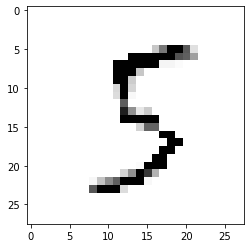

In [24]:
plt.imshow(clean_digit.reshape(28,28), cmap = 'binary')  

In [23]:
clean_digit = knn_clf.predict([X_train_mod[0]])

In [ ]:
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification.

Ahora debe saber: 

* cómo seleccionar buenas métricas para las tareas de clasificación, 
* elegir la compensación adecuada de precisión/recuperación, 
* comparar clasificadores y, en general, 
* crear buenos sistemas de clasificación para una variedad de tareas.

# Exercises


1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.   

Hint: the KNeighborsClassifier
works quite well for this task; you just need to find good
hyperparameter values (try a grid search on the weights and
n_neighbors hyperparameters).


## Referentes   

* el algoritmo de los k vacinos más cercamos: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 